# Imports

In [1]:
import pickle
import torch
import random
import math
import os
import glob
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as T
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

Dataset Mean/Std

In [2]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch[0]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      nimages += batch.size(0)
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

Data Augmentation

In [3]:
# from: https://github.com/TheRoboticsClub/gsoc2023-Meiqi_Zhao/tree/main
class ShiftAndAdjustSteer(object):
    def __init__(self, shift_fraction=0.1, steer_adjust=1.0, p=0.5):
        self.shift_fraction = shift_fraction
        self.steer_adjust = steer_adjust
        self.p = p

    def __call__(self, image, output):
        if random.random() < self.p:
            # sample a random shift
            max_shift_px = self.shift_fraction * image.shape[2]
            shift_px = torch.tensor([random.uniform(-max_shift_px, max_shift_px), 0])

            # apply the shift to the images
            shifted_img = T.affine(image, angle=0, translate=shift_px.tolist(), scale=1, shear=0, interpolation=T.InterpolationMode.NEAREST)

            # adjust the steering angle according to the shift
            shift_fraction = shift_px[0] / image.shape[2]
            shifted_steer = output[0] + self.steer_adjust * shift_fraction
            shifted_steer = torch.clamp(shifted_steer, -1.0, 1.0)

            image = shifted_img
            output[0] = shifted_steer

        return image, output

class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

Data Preprocessing

In [4]:
class AVDataset(Dataset):
    def __init__(self, data_path, resize, transform):
        self.file_paths = glob.glob(os.path.join(data_path, "*.h5"))
        self.file_paths.sort()
        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            file = h5py.File(file_path, 'r')
            self.files.append(file)
            length = file['hlc'].shape[0]
            self.lengths.append(length)
            self.total_length += length

        self.resize = resize
        self.transform = transform

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        file = self.files[file_idx]

        input_image = torch.tensor(file['image'][idx]).permute(2, 0, 1)
        speed_value = torch.tensor(file['speed'][idx][0], dtype=torch.float32)
        hlc_value = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        control_value = file['controls'][idx]
        F.one_hot(hlc_value.to(torch.int64), num_classes=4)

        if self.resize:
            input_image = T.resize(input_image, (52, 112))

        if self.transform:
            input_image, control_value = ShiftAndAdjustSteer(shift_fraction=0.15, steer_adjust=1.0, p=0.5)(input_image, control_value)
            input_image = v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=None, hue=None)(input_image)
            input_image = v2.RandomApply(torch.nn.ModuleList([v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.)),]), p=0.5)(input_image)

        input_image = input_image / 255.0
        input_image = v2.Normalize(mean=(0.4325, 0.4136, 0.3894,), std=(0.1059, 0.1040, 0.0999,))(input_image)
        control_value = torch.tensor([(control_value[0]+ 1.0) / 2.0, (control_value[1] - control_value[2] + 1.0) / 2.0], dtype=torch.float32)

        return input_image, hlc_value, speed_value, control_value

train_dataset = AVDataset(data_path='/content/drive/My Drive/AV Research/Train Data/', resize=False, transform=True)
val_dataset = AVDataset(data_path='/content/drive/My Drive/AV Research/Val Data/', resize=False, transform=False)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


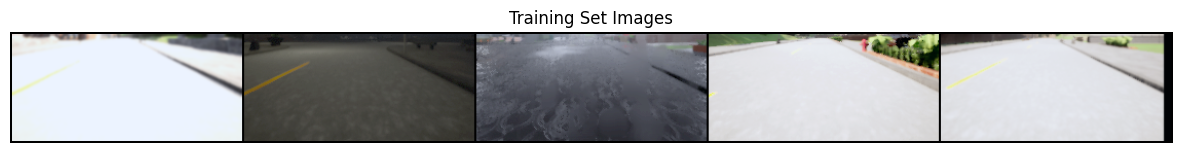

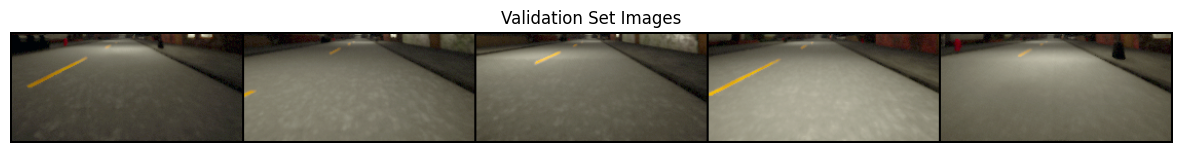

In [5]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    dataiter = iter(loader)
    images, _, _, _ = next(dataiter)
    batch_size = images.shape[0]

    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Positional Encoding

In [6]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [7]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        assert num_layers >= 2, "num_layers must be at least 2"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 2):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.out_conv = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.out_conv = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.out_conv(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

AV Model

In [37]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, bias=False),
            nn.SELU(),
        )

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=32, out_channels=32, kernel_size=3, num_layers=2, pool=True, short=True),
            ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, num_layers=2, pool=True, short=True),
            ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True),
            nn.Dropout2d(0.2),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(258, 50, bias=False),
            nn.SELU(),
            nn.Linear(50, 10, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 2)

    def forward(self, img, hlc, speed):
        x = self.input_layer(img)
        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D

        speed = speed.view(speed.size(0), -1)
        hlc = hlc.view(hlc.size(0), -1)
        x = torch.cat((x, speed, hlc), dim=1)

        x = self.dense_layers(x)
        x = self.output_layer(x)
        out = torch.sigmoid(x)
        return out

# Util

MFPE Loss

In [10]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [12]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [13]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training

Training Loop

In [14]:
def train_loop(train_loader, model, criterion, optimizer, autoclipper, device, verbose=True):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs, hlc, speed, targets = data
        inputs = inputs.float().to(device)
        hlc = hlc.to(device)
        speed = speed.to(device)
        targets = targets.float().to(device)

        outputs = model(inputs, hlc, speed)
        loss = criterion(outputs, targets)
        loss.backward()

        autoclipper(model)
        optimizer.step()

        train_loss += loss.item()
        if (batch + 1) % 100 == 0 and verbose:
            loss, current = train_loss / (batch + 1), (batch + 1) * batch_size
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss

Validation Loop

In [15]:
def val_loop(val_loader, model, criterion, device, verbose=False):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch, data in enumerate(val_loader):
            inputs, hlc, speed, targets = data
            inputs = inputs.float().to(device)
            hlc = hlc.to(device)
            speed = speed.to(device)
            targets = targets.float().to(device)
            outputs = model(inputs, hlc, speed)
            val_loss += criterion(outputs, targets).item()

            if (batch + 1) % 50 == 0 and verbose:
                print(f"Val Batch {batch + 1}")
                print(f"Outputs: {outputs[:3]})")
                print(f"Targets: {targets[:3]})")

    val_loss = val_loss / num_batches
    return val_loss

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
start_epoch = 0
num_epochs = 50
learning_rate = 1e-3

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=5)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []

# checkpoint_path = '/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_6.pt'
# if os.path.isfile(checkpoint_path):
#     model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, autoclipper, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()
    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses)

Epoch 1
-------------------------------


  3%|▎         | 101/3322 [00:16<08:21,  6.42it/s]

Training loss: 0.035369  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<07:57,  6.53it/s]

Training loss: 0.034526  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<08:06,  6.21it/s]

Training loss: 0.033805  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:49,  6.23it/s]

Training loss: 0.033628  [12800/106295]


 15%|█▌        | 501/3322 [01:20<07:53,  5.96it/s]

Training loss: 0.033355  [16000/106295]


 18%|█▊        | 601/3322 [01:36<07:26,  6.09it/s]

Training loss: 0.033084  [19200/106295]


 21%|██        | 701/3322 [01:52<06:55,  6.30it/s]

Training loss: 0.032821  [22400/106295]


 24%|██▍       | 801/3322 [02:08<06:27,  6.51it/s]

Training loss: 0.032673  [25600/106295]


 27%|██▋       | 901/3322 [02:24<06:15,  6.45it/s]

Training loss: 0.032537  [28800/106295]


 30%|███       | 1001/3322 [02:40<05:51,  6.61it/s]

Training loss: 0.032477  [32000/106295]


 33%|███▎      | 1101/3322 [02:55<05:56,  6.24it/s]

Training loss: 0.032410  [35200/106295]


 36%|███▌      | 1201/3322 [03:11<05:32,  6.38it/s]

Training loss: 0.032313  [38400/106295]


 39%|███▉      | 1301/3322 [03:27<05:16,  6.38it/s]

Training loss: 0.032121  [41600/106295]


 42%|████▏     | 1401/3322 [03:43<04:51,  6.59it/s]

Training loss: 0.032050  [44800/106295]


 45%|████▌     | 1501/3322 [03:58<05:01,  6.05it/s]

Training loss: 0.031901  [48000/106295]


 48%|████▊     | 1601/3322 [04:14<04:45,  6.03it/s]

Training loss: 0.031852  [51200/106295]


 51%|█████     | 1701/3322 [04:30<04:05,  6.61it/s]

Training loss: 0.031789  [54400/106295]


 54%|█████▍    | 1801/3322 [04:46<03:57,  6.39it/s]

Training loss: 0.031738  [57600/106295]


 57%|█████▋    | 1901/3322 [05:02<03:39,  6.46it/s]

Training loss: 0.031672  [60800/106295]


 60%|██████    | 2001/3322 [05:18<03:36,  6.11it/s]

Training loss: 0.031532  [64000/106295]


 63%|██████▎   | 2101/3322 [05:34<03:25,  5.93it/s]

Training loss: 0.031458  [67200/106295]


 66%|██████▋   | 2201/3322 [05:50<02:58,  6.30it/s]

Training loss: 0.031321  [70400/106295]


 69%|██████▉   | 2301/3322 [06:05<02:45,  6.17it/s]

Training loss: 0.031226  [73600/106295]


 72%|███████▏  | 2401/3322 [06:22<02:33,  6.00it/s]

Training loss: 0.031166  [76800/106295]


 75%|███████▌  | 2501/3322 [06:37<02:07,  6.42it/s]

Training loss: 0.031097  [80000/106295]


 78%|███████▊  | 2601/3322 [06:53<01:59,  6.04it/s]

Training loss: 0.031001  [83200/106295]


 81%|████████▏ | 2701/3322 [07:09<01:37,  6.34it/s]

Training loss: 0.030934  [86400/106295]


 84%|████████▍ | 2801/3322 [07:25<01:20,  6.44it/s]

Training loss: 0.030836  [89600/106295]


 87%|████████▋ | 2901/3322 [07:41<01:07,  6.21it/s]

Training loss: 0.030809  [92800/106295]


 90%|█████████ | 3001/3322 [07:56<00:49,  6.50it/s]

Training loss: 0.030721  [96000/106295]


 93%|█████████▎| 3101/3322 [08:12<00:35,  6.22it/s]

Training loss: 0.030666  [99200/106295]


 96%|█████████▋| 3201/3322 [08:28<00:19,  6.27it/s]

Training loss: 0.030596  [102400/106295]


 99%|█████████▉| 3301/3322 [08:43<00:03,  6.27it/s]

Training loss: 0.030538  [105600/106295]


100%|██████████| 3322/3322 [08:47<00:00,  6.30it/s]


Train loss: 0.030519 - Val loss: 0.019279 

Last learning rate: [0.001]
Epoch 2
-------------------------------


  3%|▎         | 101/3322 [00:16<08:12,  6.55it/s]

Training loss: 0.027911  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:07,  6.40it/s]

Training loss: 0.028487  [ 6400/106295]


  9%|▉         | 301/3322 [00:48<08:13,  6.12it/s]

Training loss: 0.028708  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:34,  6.42it/s]

Training loss: 0.028676  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:48,  6.02it/s]

Training loss: 0.028689  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:11,  6.30it/s]

Training loss: 0.028371  [19200/106295]


 21%|██        | 701/3322 [01:51<07:02,  6.21it/s]

Training loss: 0.028292  [22400/106295]


 24%|██▍       | 801/3322 [02:07<07:03,  5.95it/s]

Training loss: 0.028207  [25600/106295]


 27%|██▋       | 901/3322 [02:23<06:38,  6.07it/s]

Training loss: 0.028169  [28800/106295]


 30%|███       | 1001/3322 [02:40<06:13,  6.22it/s]

Training loss: 0.028207  [32000/106295]


 33%|███▎      | 1101/3322 [02:56<05:55,  6.25it/s]

Training loss: 0.028178  [35200/106295]


 36%|███▌      | 1201/3322 [03:13<05:33,  6.35it/s]

Training loss: 0.028134  [38400/106295]


 39%|███▉      | 1301/3322 [03:29<05:34,  6.04it/s]

Training loss: 0.028147  [41600/106295]


 42%|████▏     | 1401/3322 [03:46<05:08,  6.22it/s]

Training loss: 0.028122  [44800/106295]


 45%|████▌     | 1501/3322 [04:02<04:53,  6.21it/s]

Training loss: 0.028113  [48000/106295]


 48%|████▊     | 1601/3322 [04:18<04:32,  6.30it/s]

Training loss: 0.028121  [51200/106295]


 51%|█████     | 1701/3322 [04:34<04:31,  5.96it/s]

Training loss: 0.028078  [54400/106295]


 54%|█████▍    | 1801/3322 [04:51<04:03,  6.25it/s]

Training loss: 0.028035  [57600/106295]


 57%|█████▋    | 1901/3322 [05:07<03:50,  6.17it/s]

Training loss: 0.028049  [60800/106295]


 60%|██████    | 2001/3322 [05:23<03:36,  6.11it/s]

Training loss: 0.028041  [64000/106295]


 63%|██████▎   | 2101/3322 [05:40<03:22,  6.02it/s]

Training loss: 0.028070  [67200/106295]


 66%|██████▋   | 2201/3322 [05:56<02:56,  6.37it/s]

Training loss: 0.028043  [70400/106295]


 69%|██████▉   | 2301/3322 [06:12<02:43,  6.24it/s]

Training loss: 0.028059  [73600/106295]


 72%|███████▏  | 2401/3322 [06:28<02:26,  6.28it/s]

Training loss: 0.027995  [76800/106295]


 75%|███████▌  | 2501/3322 [06:45<02:13,  6.16it/s]

Training loss: 0.027973  [80000/106295]


 78%|███████▊  | 2601/3322 [07:01<01:56,  6.21it/s]

Training loss: 0.027956  [83200/106295]


 81%|████████▏ | 2701/3322 [07:17<01:42,  6.03it/s]

Training loss: 0.027968  [86400/106295]


 84%|████████▍ | 2801/3322 [07:33<01:22,  6.32it/s]

Training loss: 0.027952  [89600/106295]


 87%|████████▋ | 2901/3322 [07:50<01:06,  6.34it/s]

Training loss: 0.027926  [92800/106295]


 90%|█████████ | 3001/3322 [08:06<00:51,  6.26it/s]

Training loss: 0.027928  [96000/106295]


 93%|█████████▎| 3101/3322 [08:22<00:34,  6.39it/s]

Training loss: 0.027913  [99200/106295]


 96%|█████████▋| 3201/3322 [08:38<00:19,  6.29it/s]

Training loss: 0.027879  [102400/106295]


 99%|█████████▉| 3301/3322 [08:55<00:03,  6.09it/s]

Training loss: 0.027853  [105600/106295]


100%|██████████| 3322/3322 [08:58<00:00,  6.17it/s]


Train loss: 0.027851 - Val loss: 0.017848 

Last learning rate: [0.0009990133642141358]
Epoch 3
-------------------------------


  3%|▎         | 101/3322 [00:16<08:16,  6.49it/s]

Training loss: 0.025790  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<07:51,  6.62it/s]

Training loss: 0.026681  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:49,  6.43it/s]

Training loss: 0.026337  [ 9600/106295]


 12%|█▏        | 401/3322 [01:04<08:04,  6.03it/s]

Training loss: 0.026382  [12800/106295]


 15%|█▌        | 501/3322 [01:20<07:57,  5.91it/s]

Training loss: 0.026569  [16000/106295]


 18%|█▊        | 601/3322 [01:36<07:00,  6.48it/s]

Training loss: 0.026832  [19200/106295]


 21%|██        | 701/3322 [01:51<06:38,  6.58it/s]

Training loss: 0.026927  [22400/106295]


 24%|██▍       | 801/3322 [02:07<06:31,  6.43it/s]

Training loss: 0.026886  [25600/106295]


 27%|██▋       | 901/3322 [02:23<06:11,  6.52it/s]

Training loss: 0.026880  [28800/106295]


 30%|███       | 1001/3322 [02:38<06:03,  6.38it/s]

Training loss: 0.026844  [32000/106295]


 33%|███▎      | 1101/3322 [02:54<05:40,  6.53it/s]

Training loss: 0.026950  [35200/106295]


 36%|███▌      | 1201/3322 [03:09<05:37,  6.29it/s]

Training loss: 0.026967  [38400/106295]


 39%|███▉      | 1301/3322 [03:25<05:11,  6.48it/s]

Training loss: 0.026948  [41600/106295]


 42%|████▏     | 1401/3322 [03:41<05:03,  6.33it/s]

Training loss: 0.026875  [44800/106295]


 45%|████▌     | 1501/3322 [03:56<04:50,  6.27it/s]

Training loss: 0.026869  [48000/106295]


 48%|████▊     | 1601/3322 [04:12<04:34,  6.26it/s]

Training loss: 0.026807  [51200/106295]


 51%|█████     | 1701/3322 [04:27<04:04,  6.63it/s]

Training loss: 0.026794  [54400/106295]


 54%|█████▍    | 1801/3322 [04:43<03:50,  6.59it/s]

Training loss: 0.026728  [57600/106295]


 57%|█████▋    | 1901/3322 [04:59<03:41,  6.41it/s]

Training loss: 0.026701  [60800/106295]


 60%|██████    | 2001/3322 [05:14<03:19,  6.61it/s]

Training loss: 0.026727  [64000/106295]


 63%|██████▎   | 2101/3322 [05:30<03:07,  6.52it/s]

Training loss: 0.026703  [67200/106295]


 66%|██████▋   | 2201/3322 [05:45<02:46,  6.75it/s]

Training loss: 0.026713  [70400/106295]


 69%|██████▉   | 2301/3322 [06:01<02:44,  6.21it/s]

Training loss: 0.026677  [73600/106295]


 72%|███████▏  | 2401/3322 [06:16<02:17,  6.70it/s]

Training loss: 0.026634  [76800/106295]


 75%|███████▌  | 2501/3322 [06:32<02:04,  6.61it/s]

Training loss: 0.026597  [80000/106295]


 78%|███████▊  | 2601/3322 [06:48<01:50,  6.55it/s]

Training loss: 0.026591  [83200/106295]


 81%|████████▏ | 2701/3322 [07:03<01:35,  6.49it/s]

Training loss: 0.026536  [86400/106295]


 84%|████████▍ | 2801/3322 [07:19<01:22,  6.34it/s]

Training loss: 0.026509  [89600/106295]


 87%|████████▋ | 2901/3322 [07:34<01:05,  6.40it/s]

Training loss: 0.026511  [92800/106295]


 90%|█████████ | 3001/3322 [07:50<00:49,  6.42it/s]

Training loss: 0.026483  [96000/106295]


 93%|█████████▎| 3101/3322 [08:06<00:33,  6.54it/s]

Training loss: 0.026491  [99200/106295]


 96%|█████████▋| 3201/3322 [08:21<00:19,  6.31it/s]

Training loss: 0.026449  [102400/106295]


 99%|█████████▉| 3301/3322 [08:37<00:03,  6.57it/s]

Training loss: 0.026416  [105600/106295]


100%|██████████| 3322/3322 [08:40<00:00,  6.38it/s]


Train loss: 0.026392 - Val loss: 0.016930 

Last learning rate: [0.000996057350657239]
Epoch 4
-------------------------------


  3%|▎         | 101/3322 [00:16<08:27,  6.35it/s]

Training loss: 0.026312  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:24,  6.19it/s]

Training loss: 0.026141  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<08:09,  6.17it/s]

Training loss: 0.025429  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:53,  6.17it/s]

Training loss: 0.025689  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:14,  6.50it/s]

Training loss: 0.025817  [16000/106295]


 18%|█▊        | 601/3322 [01:34<06:56,  6.54it/s]

Training loss: 0.025715  [19200/106295]


 21%|██        | 701/3322 [01:50<06:40,  6.54it/s]

Training loss: 0.025695  [22400/106295]


 24%|██▍       | 801/3322 [02:05<06:27,  6.51it/s]

Training loss: 0.025614  [25600/106295]


 27%|██▋       | 901/3322 [02:21<06:16,  6.43it/s]

Training loss: 0.025608  [28800/106295]


 30%|███       | 1001/3322 [02:37<06:09,  6.29it/s]

Training loss: 0.025679  [32000/106295]


 33%|███▎      | 1101/3322 [02:53<05:51,  6.31it/s]

Training loss: 0.025734  [35200/106295]


 36%|███▌      | 1201/3322 [03:08<05:34,  6.34it/s]

Training loss: 0.025695  [38400/106295]


 39%|███▉      | 1301/3322 [03:24<05:20,  6.31it/s]

Training loss: 0.025632  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:04,  6.30it/s]

Training loss: 0.025652  [44800/106295]


 45%|████▌     | 1501/3322 [03:55<04:42,  6.44it/s]

Training loss: 0.025642  [48000/106295]


 48%|████▊     | 1601/3322 [04:11<04:27,  6.43it/s]

Training loss: 0.025589  [51200/106295]


 51%|█████     | 1701/3322 [04:27<04:25,  6.12it/s]

Training loss: 0.025538  [54400/106295]


 54%|█████▍    | 1801/3322 [04:42<04:01,  6.30it/s]

Training loss: 0.025526  [57600/106295]


 57%|█████▋    | 1901/3322 [04:58<03:36,  6.56it/s]

Training loss: 0.025537  [60800/106295]


 60%|██████    | 2001/3322 [05:13<03:26,  6.41it/s]

Training loss: 0.025491  [64000/106295]


 63%|██████▎   | 2101/3322 [05:29<03:02,  6.68it/s]

Training loss: 0.025528  [67200/106295]


 66%|██████▋   | 2201/3322 [05:45<02:50,  6.56it/s]

Training loss: 0.025513  [70400/106295]


 69%|██████▉   | 2301/3322 [06:00<02:35,  6.58it/s]

Training loss: 0.025453  [73600/106295]


 72%|███████▏  | 2401/3322 [06:16<02:26,  6.27it/s]

Training loss: 0.025440  [76800/106295]


 75%|███████▌  | 2501/3322 [06:31<02:05,  6.53it/s]

Training loss: 0.025449  [80000/106295]


 78%|███████▊  | 2601/3322 [06:47<01:47,  6.70it/s]

Training loss: 0.025444  [83200/106295]


 81%|████████▏ | 2701/3322 [07:03<01:36,  6.43it/s]

Training loss: 0.025452  [86400/106295]


 84%|████████▍ | 2801/3322 [07:19<01:20,  6.43it/s]

Training loss: 0.025416  [89600/106295]


 87%|████████▋ | 2901/3322 [07:34<01:05,  6.40it/s]

Training loss: 0.025418  [92800/106295]


 90%|█████████ | 3001/3322 [07:50<00:50,  6.40it/s]

Training loss: 0.025400  [96000/106295]


 93%|█████████▎| 3101/3322 [08:06<00:36,  6.11it/s]

Training loss: 0.025406  [99200/106295]


 96%|█████████▋| 3201/3322 [08:21<00:18,  6.50it/s]

Training loss: 0.025432  [102400/106295]


 99%|█████████▉| 3301/3322 [08:37<00:03,  6.38it/s]

Training loss: 0.025429  [105600/106295]


100%|██████████| 3322/3322 [08:40<00:00,  6.38it/s]


Train loss: 0.025426 - Val loss: 0.015713 

Last learning rate: [0.0009911436253643444]
Epoch 5
-------------------------------


  3%|▎         | 101/3322 [00:16<08:03,  6.66it/s]

Training loss: 0.025239  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:29,  6.12it/s]

Training loss: 0.024952  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:46,  6.48it/s]

Training loss: 0.025011  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:31,  6.47it/s]

Training loss: 0.024878  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:18,  6.43it/s]

Training loss: 0.024871  [16000/106295]


 18%|█▊        | 601/3322 [01:34<07:18,  6.21it/s]

Training loss: 0.024845  [19200/106295]


 21%|██        | 701/3322 [01:50<07:15,  6.01it/s]

Training loss: 0.024808  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:53,  6.09it/s]

Training loss: 0.024775  [25600/106295]


 27%|██▋       | 901/3322 [02:22<06:29,  6.21it/s]

Training loss: 0.024783  [28800/106295]


 30%|███       | 1001/3322 [02:38<06:18,  6.13it/s]

Training loss: 0.024807  [32000/106295]


 33%|███▎      | 1101/3322 [02:54<05:50,  6.34it/s]

Training loss: 0.024797  [35200/106295]


 36%|███▌      | 1201/3322 [03:10<05:36,  6.30it/s]

Training loss: 0.024800  [38400/106295]


 39%|███▉      | 1301/3322 [03:26<05:22,  6.27it/s]

Training loss: 0.024724  [41600/106295]


 42%|████▏     | 1401/3322 [03:43<05:05,  6.29it/s]

Training loss: 0.024742  [44800/106295]


 45%|████▌     | 1501/3322 [03:59<04:56,  6.14it/s]

Training loss: 0.024746  [48000/106295]


 48%|████▊     | 1601/3322 [04:15<04:30,  6.36it/s]

Training loss: 0.024754  [51200/106295]


 51%|█████     | 1701/3322 [04:31<04:35,  5.88it/s]

Training loss: 0.024813  [54400/106295]


 54%|█████▍    | 1801/3322 [04:47<04:03,  6.25it/s]

Training loss: 0.024762  [57600/106295]


 57%|█████▋    | 1901/3322 [05:03<03:41,  6.42it/s]

Training loss: 0.024761  [60800/106295]


 60%|██████    | 2001/3322 [05:19<03:49,  5.76it/s]

Training loss: 0.024785  [64000/106295]


 63%|██████▎   | 2101/3322 [05:36<03:16,  6.22it/s]

Training loss: 0.024810  [67200/106295]


 66%|██████▋   | 2201/3322 [05:52<03:04,  6.07it/s]

Training loss: 0.024774  [70400/106295]


 69%|██████▉   | 2301/3322 [06:08<02:49,  6.01it/s]

Training loss: 0.024801  [73600/106295]


 72%|███████▏  | 2401/3322 [06:24<02:29,  6.17it/s]

Training loss: 0.024789  [76800/106295]


 75%|███████▌  | 2501/3322 [06:41<02:10,  6.30it/s]

Training loss: 0.024740  [80000/106295]


 78%|███████▊  | 2601/3322 [06:57<01:58,  6.11it/s]

Training loss: 0.024714  [83200/106295]


 81%|████████▏ | 2701/3322 [07:13<01:37,  6.37it/s]

Training loss: 0.024688  [86400/106295]


 84%|████████▍ | 2801/3322 [07:29<01:25,  6.10it/s]

Training loss: 0.024674  [89600/106295]


 87%|████████▋ | 2901/3322 [07:45<01:13,  5.70it/s]

Training loss: 0.024669  [92800/106295]


 90%|█████████ | 3001/3322 [08:02<00:51,  6.25it/s]

Training loss: 0.024680  [96000/106295]


 93%|█████████▎| 3101/3322 [08:18<00:36,  6.12it/s]

Training loss: 0.024679  [99200/106295]


 96%|█████████▋| 3201/3322 [08:34<00:19,  6.08it/s]

Training loss: 0.024658  [102400/106295]


 99%|█████████▉| 3301/3322 [08:50<00:03,  6.26it/s]

Training loss: 0.024629  [105600/106295]


100%|██████████| 3322/3322 [08:54<00:00,  6.22it/s]


Train loss: 0.024634 - Val loss: 0.015897 

Last learning rate: [0.0009842915805643156]
Epoch 6
-------------------------------


  3%|▎         | 101/3322 [00:16<08:25,  6.37it/s]

Training loss: 0.023373  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:16,  6.28it/s]

Training loss: 0.023915  [ 6400/106295]


  9%|▉         | 301/3322 [00:48<07:48,  6.44it/s]

Training loss: 0.023649  [ 9600/106295]


 12%|█▏        | 401/3322 [01:04<07:36,  6.40it/s]

Training loss: 0.023870  [12800/106295]


 15%|█▌        | 501/3322 [01:20<07:17,  6.45it/s]

Training loss: 0.024119  [16000/106295]


 18%|█▊        | 601/3322 [01:36<07:02,  6.44it/s]

Training loss: 0.024389  [19200/106295]


 21%|██        | 701/3322 [01:52<07:00,  6.23it/s]

Training loss: 0.024384  [22400/106295]


 24%|██▍       | 801/3322 [02:08<07:04,  5.93it/s]

Training loss: 0.024284  [25600/106295]


 27%|██▋       | 901/3322 [02:25<06:47,  5.94it/s]

Training loss: 0.024270  [28800/106295]


 30%|███       | 1001/3322 [02:41<06:20,  6.10it/s]

Training loss: 0.024272  [32000/106295]


 33%|███▎      | 1101/3322 [02:57<05:52,  6.31it/s]

Training loss: 0.024286  [35200/106295]


 36%|███▌      | 1201/3322 [03:13<05:35,  6.32it/s]

Training loss: 0.024242  [38400/106295]


 39%|███▉      | 1301/3322 [03:29<05:19,  6.32it/s]

Training loss: 0.024278  [41600/106295]


 42%|████▏     | 1401/3322 [03:45<05:22,  5.95it/s]

Training loss: 0.024211  [44800/106295]


 45%|████▌     | 1501/3322 [04:01<04:59,  6.07it/s]

Training loss: 0.024180  [48000/106295]


 48%|████▊     | 1601/3322 [04:17<04:28,  6.42it/s]

Training loss: 0.024218  [51200/106295]


 51%|█████     | 1701/3322 [04:33<04:31,  5.97it/s]

Training loss: 0.024153  [54400/106295]


 54%|█████▍    | 1801/3322 [04:49<03:57,  6.40it/s]

Training loss: 0.024199  [57600/106295]


 57%|█████▋    | 1901/3322 [05:05<03:42,  6.38it/s]

Training loss: 0.024185  [60800/106295]


 60%|██████    | 2001/3322 [05:21<03:28,  6.34it/s]

Training loss: 0.024137  [64000/106295]


 63%|██████▎   | 2101/3322 [05:37<03:15,  6.26it/s]

Training loss: 0.024170  [67200/106295]


 66%|██████▋   | 2201/3322 [05:53<02:56,  6.35it/s]

Training loss: 0.024228  [70400/106295]


 69%|██████▉   | 2301/3322 [06:09<02:49,  6.02it/s]

Training loss: 0.024206  [73600/106295]


 72%|███████▏  | 2401/3322 [06:25<02:25,  6.31it/s]

Training loss: 0.024180  [76800/106295]


 75%|███████▌  | 2501/3322 [06:41<02:14,  6.12it/s]

Training loss: 0.024173  [80000/106295]


 78%|███████▊  | 2601/3322 [06:57<01:55,  6.27it/s]

Training loss: 0.024113  [83200/106295]


 81%|████████▏ | 2701/3322 [07:13<01:43,  5.98it/s]

Training loss: 0.024105  [86400/106295]


 84%|████████▍ | 2801/3322 [07:29<01:22,  6.31it/s]

Training loss: 0.024099  [89600/106295]


 87%|████████▋ | 2901/3322 [07:45<01:03,  6.59it/s]

Training loss: 0.024095  [92800/106295]


 90%|█████████ | 3001/3322 [08:01<00:50,  6.34it/s]

Training loss: 0.024111  [96000/106295]


 93%|█████████▎| 3101/3322 [08:17<00:34,  6.43it/s]

Training loss: 0.024125  [99200/106295]


 96%|█████████▋| 3201/3322 [08:33<00:20,  6.01it/s]

Training loss: 0.024095  [102400/106295]


 99%|█████████▉| 3301/3322 [08:49<00:03,  6.09it/s]

Training loss: 0.024116  [105600/106295]


100%|██████████| 3322/3322 [08:52<00:00,  6.23it/s]


Train loss: 0.024111 - Val loss: 0.016310 

Last learning rate: [0.0009755282581475769]
Epoch 7
-------------------------------


  3%|▎         | 101/3322 [00:16<08:50,  6.07it/s]

Training loss: 0.023612  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:51,  5.87it/s]

Training loss: 0.023593  [ 6400/106295]


  9%|▉         | 301/3322 [00:48<07:55,  6.35it/s]

Training loss: 0.023379  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:30,  6.49it/s]

Training loss: 0.023438  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:30,  6.27it/s]

Training loss: 0.023412  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:09,  6.33it/s]

Training loss: 0.023548  [19200/106295]


 21%|██        | 701/3322 [01:51<06:46,  6.45it/s]

Training loss: 0.023648  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:55,  6.07it/s]

Training loss: 0.023684  [25600/106295]


 27%|██▋       | 901/3322 [02:22<06:27,  6.25it/s]

Training loss: 0.023734  [28800/106295]


 30%|███       | 1001/3322 [02:38<06:02,  6.40it/s]

Training loss: 0.023582  [32000/106295]


 33%|███▎      | 1101/3322 [02:54<05:54,  6.26it/s]

Training loss: 0.023564  [35200/106295]


 36%|███▌      | 1201/3322 [03:10<05:34,  6.35it/s]

Training loss: 0.023599  [38400/106295]


 39%|███▉      | 1301/3322 [03:26<05:21,  6.28it/s]

Training loss: 0.023600  [41600/106295]


 42%|████▏     | 1401/3322 [03:42<05:00,  6.39it/s]

Training loss: 0.023642  [44800/106295]


 45%|████▌     | 1501/3322 [03:58<04:49,  6.29it/s]

Training loss: 0.023599  [48000/106295]


 48%|████▊     | 1601/3322 [04:14<04:39,  6.17it/s]

Training loss: 0.023574  [51200/106295]


 51%|█████     | 1701/3322 [04:30<04:14,  6.37it/s]

Training loss: 0.023552  [54400/106295]


 54%|█████▍    | 1801/3322 [04:46<03:59,  6.35it/s]

Training loss: 0.023577  [57600/106295]


 57%|█████▋    | 1901/3322 [05:02<03:58,  5.95it/s]

Training loss: 0.023565  [60800/106295]


 60%|██████    | 2001/3322 [05:18<03:29,  6.29it/s]

Training loss: 0.023612  [64000/106295]


 63%|██████▎   | 2101/3322 [05:34<03:11,  6.38it/s]

Training loss: 0.023604  [67200/106295]


 66%|██████▋   | 2201/3322 [05:50<02:55,  6.37it/s]

Training loss: 0.023553  [70400/106295]


 69%|██████▉   | 2301/3322 [06:06<02:38,  6.43it/s]

Training loss: 0.023550  [73600/106295]


 72%|███████▏  | 2401/3322 [06:22<02:29,  6.18it/s]

Training loss: 0.023540  [76800/106295]


 75%|███████▌  | 2501/3322 [06:38<02:12,  6.19it/s]

Training loss: 0.023576  [80000/106295]


 78%|███████▊  | 2601/3322 [06:54<01:54,  6.29it/s]

Training loss: 0.023597  [83200/106295]


 81%|████████▏ | 2701/3322 [07:09<01:35,  6.51it/s]

Training loss: 0.023644  [86400/106295]


 84%|████████▍ | 2801/3322 [07:25<01:23,  6.22it/s]

Training loss: 0.023590  [89600/106295]


 87%|████████▋ | 2901/3322 [07:41<01:08,  6.13it/s]

Training loss: 0.023613  [92800/106295]


 90%|█████████ | 3001/3322 [07:56<00:51,  6.24it/s]

Training loss: 0.023634  [96000/106295]


 93%|█████████▎| 3101/3322 [08:12<00:33,  6.65it/s]

Training loss: 0.023643  [99200/106295]


 96%|█████████▋| 3201/3322 [08:28<00:19,  6.37it/s]

Training loss: 0.023631  [102400/106295]


 99%|█████████▉| 3301/3322 [08:44<00:03,  6.40it/s]

Training loss: 0.023606  [105600/106295]


100%|██████████| 3322/3322 [08:47<00:00,  6.30it/s]


Train loss: 0.023598 - Val loss: 0.015554 

Last learning rate: [0.0009648882429441258]
Epoch 8
-------------------------------


  3%|▎         | 101/3322 [00:16<08:24,  6.38it/s]

Training loss: 0.024303  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:40,  6.00it/s]

Training loss: 0.023780  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:46,  6.47it/s]

Training loss: 0.023891  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:22,  6.60it/s]

Training loss: 0.023762  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:31,  6.24it/s]

Training loss: 0.023743  [16000/106295]


 18%|█▊        | 601/3322 [01:34<07:10,  6.33it/s]

Training loss: 0.023727  [19200/106295]


 21%|██        | 701/3322 [01:49<06:34,  6.65it/s]

Training loss: 0.023550  [22400/106295]


 24%|██▍       | 801/3322 [02:05<06:26,  6.52it/s]

Training loss: 0.023534  [25600/106295]


 27%|██▋       | 901/3322 [02:21<06:17,  6.41it/s]

Training loss: 0.023472  [28800/106295]


 30%|███       | 1001/3322 [02:36<05:50,  6.61it/s]

Training loss: 0.023421  [32000/106295]


 33%|███▎      | 1101/3322 [02:52<05:40,  6.53it/s]

Training loss: 0.023476  [35200/106295]


 36%|███▌      | 1201/3322 [03:07<05:28,  6.46it/s]

Training loss: 0.023506  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:08,  6.56it/s]

Training loss: 0.023478  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:12,  6.15it/s]

Training loss: 0.023507  [44800/106295]


 45%|████▌     | 1501/3322 [03:54<04:37,  6.56it/s]

Training loss: 0.023472  [48000/106295]


 48%|████▊     | 1601/3322 [04:10<04:35,  6.24it/s]

Training loss: 0.023453  [51200/106295]


 51%|█████     | 1701/3322 [04:25<04:09,  6.51it/s]

Training loss: 0.023465  [54400/106295]


 54%|█████▍    | 1801/3322 [04:41<04:01,  6.29it/s]

Training loss: 0.023421  [57600/106295]


 57%|█████▋    | 1901/3322 [04:57<03:59,  5.94it/s]

Training loss: 0.023409  [60800/106295]


 60%|██████    | 2001/3322 [05:13<03:41,  5.96it/s]

Training loss: 0.023367  [64000/106295]


 63%|██████▎   | 2101/3322 [05:28<03:09,  6.45it/s]

Training loss: 0.023330  [67200/106295]


 66%|██████▋   | 2201/3322 [05:44<02:56,  6.34it/s]

Training loss: 0.023276  [70400/106295]


 69%|██████▉   | 2301/3322 [05:59<02:40,  6.37it/s]

Training loss: 0.023255  [73600/106295]


 72%|███████▏  | 2401/3322 [06:15<02:23,  6.41it/s]

Training loss: 0.023260  [76800/106295]


 75%|███████▌  | 2501/3322 [06:31<02:10,  6.28it/s]

Training loss: 0.023253  [80000/106295]


 78%|███████▊  | 2601/3322 [06:46<01:55,  6.24it/s]

Training loss: 0.023274  [83200/106295]


 81%|████████▏ | 2701/3322 [07:02<01:39,  6.26it/s]

Training loss: 0.023273  [86400/106295]


 84%|████████▍ | 2801/3322 [07:18<01:19,  6.57it/s]

Training loss: 0.023271  [89600/106295]


 87%|████████▋ | 2901/3322 [07:33<01:05,  6.47it/s]

Training loss: 0.023255  [92800/106295]


 90%|█████████ | 3001/3322 [07:49<00:46,  6.85it/s]

Training loss: 0.023261  [96000/106295]


 93%|█████████▎| 3101/3322 [08:04<00:35,  6.23it/s]

Training loss: 0.023257  [99200/106295]


 96%|█████████▋| 3201/3322 [08:20<00:18,  6.44it/s]

Training loss: 0.023251  [102400/106295]


 99%|█████████▉| 3301/3322 [08:36<00:03,  6.36it/s]

Training loss: 0.023238  [105600/106295]


100%|██████████| 3322/3322 [08:39<00:00,  6.40it/s]


Train loss: 0.023244 - Val loss: 0.016020 

Last learning rate: [0.0009524135262330099]
Epoch 9
-------------------------------


  3%|▎         | 101/3322 [00:16<08:35,  6.25it/s]

Training loss: 0.022281  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:13,  6.33it/s]

Training loss: 0.022758  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:46,  6.47it/s]

Training loss: 0.022647  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:17,  6.68it/s]

Training loss: 0.022627  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:08,  6.59it/s]

Training loss: 0.022771  [16000/106295]


 18%|█▊        | 601/3322 [01:34<06:56,  6.54it/s]

Training loss: 0.022921  [19200/106295]


 21%|██        | 701/3322 [01:49<06:39,  6.56it/s]

Training loss: 0.022783  [22400/106295]


 24%|██▍       | 801/3322 [02:05<06:18,  6.66it/s]

Training loss: 0.022684  [25600/106295]


 27%|██▋       | 901/3322 [02:20<06:16,  6.43it/s]

Training loss: 0.022695  [28800/106295]


 30%|███       | 1001/3322 [02:36<06:06,  6.34it/s]

Training loss: 0.022633  [32000/106295]


 33%|███▎      | 1101/3322 [02:52<05:56,  6.22it/s]

Training loss: 0.022653  [35200/106295]


 36%|███▌      | 1201/3322 [03:07<05:29,  6.44it/s]

Training loss: 0.022700  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:13,  6.44it/s]

Training loss: 0.022672  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:00,  6.39it/s]

Training loss: 0.022722  [44800/106295]


 45%|████▌     | 1501/3322 [03:55<04:58,  6.09it/s]

Training loss: 0.022774  [48000/106295]


 48%|████▊     | 1601/3322 [04:10<04:37,  6.20it/s]

Training loss: 0.022776  [51200/106295]


 51%|█████     | 1701/3322 [04:26<04:14,  6.38it/s]

Training loss: 0.022757  [54400/106295]


 54%|█████▍    | 1801/3322 [04:42<04:16,  5.93it/s]

Training loss: 0.022726  [57600/106295]


 57%|█████▋    | 1901/3322 [04:57<03:41,  6.42it/s]

Training loss: 0.022748  [60800/106295]


 60%|██████    | 2001/3322 [05:13<03:19,  6.61it/s]

Training loss: 0.022782  [64000/106295]


 63%|██████▎   | 2101/3322 [05:28<03:06,  6.53it/s]

Training loss: 0.022827  [67200/106295]


 66%|██████▋   | 2201/3322 [05:44<02:59,  6.24it/s]

Training loss: 0.022806  [70400/106295]


 69%|██████▉   | 2301/3322 [05:59<02:42,  6.29it/s]

Training loss: 0.022809  [73600/106295]


 72%|███████▏  | 2401/3322 [06:15<02:22,  6.46it/s]

Training loss: 0.022843  [76800/106295]


 75%|███████▌  | 2501/3322 [06:30<02:15,  6.05it/s]

Training loss: 0.022830  [80000/106295]


 78%|███████▊  | 2601/3322 [06:46<01:47,  6.71it/s]

Training loss: 0.022810  [83200/106295]


 81%|████████▏ | 2701/3322 [07:02<01:42,  6.06it/s]

Training loss: 0.022813  [86400/106295]


 84%|████████▍ | 2801/3322 [07:17<01:22,  6.30it/s]

Training loss: 0.022813  [89600/106295]


 87%|████████▋ | 2901/3322 [07:33<01:06,  6.29it/s]

Training loss: 0.022834  [92800/106295]


 90%|█████████ | 3001/3322 [07:48<00:48,  6.56it/s]

Training loss: 0.022840  [96000/106295]


 93%|█████████▎| 3101/3322 [08:04<00:34,  6.46it/s]

Training loss: 0.022841  [99200/106295]


 96%|█████████▋| 3201/3322 [08:19<00:19,  6.32it/s]

Training loss: 0.022842  [102400/106295]


 99%|█████████▉| 3301/3322 [08:35<00:03,  6.45it/s]

Training loss: 0.022822  [105600/106295]


100%|██████████| 3322/3322 [08:38<00:00,  6.40it/s]


Train loss: 0.022825 - Val loss: 0.015770 

Last learning rate: [0.0009381533400219318]
Epoch 10
-------------------------------


  3%|▎         | 101/3322 [00:16<08:40,  6.19it/s]

Training loss: 0.022066  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:41,  5.99it/s]

Training loss: 0.022472  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:58,  6.31it/s]

Training loss: 0.022414  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:44,  6.28it/s]

Training loss: 0.022528  [12800/106295]


 15%|█▌        | 501/3322 [01:20<07:35,  6.19it/s]

Training loss: 0.022539  [16000/106295]


 18%|█▊        | 601/3322 [01:35<06:57,  6.51it/s]

Training loss: 0.022593  [19200/106295]


 21%|██        | 701/3322 [01:51<06:38,  6.58it/s]

Training loss: 0.022570  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:44,  6.23it/s]

Training loss: 0.022548  [25600/106295]


 27%|██▋       | 901/3322 [02:22<06:04,  6.65it/s]

Training loss: 0.022570  [28800/106295]


 30%|███       | 1001/3322 [02:37<06:10,  6.27it/s]

Training loss: 0.022576  [32000/106295]


 33%|███▎      | 1101/3322 [02:53<05:42,  6.49it/s]

Training loss: 0.022551  [35200/106295]


 36%|███▌      | 1201/3322 [03:09<05:39,  6.25it/s]

Training loss: 0.022492  [38400/106295]


 39%|███▉      | 1301/3322 [03:24<05:04,  6.64it/s]

Training loss: 0.022523  [41600/106295]


 42%|████▏     | 1401/3322 [03:40<05:22,  5.95it/s]

Training loss: 0.022498  [44800/106295]


 45%|████▌     | 1501/3322 [03:56<04:39,  6.52it/s]

Training loss: 0.022480  [48000/106295]


 48%|████▊     | 1601/3322 [04:12<04:31,  6.34it/s]

Training loss: 0.022437  [51200/106295]


 51%|█████     | 1701/3322 [04:27<04:16,  6.32it/s]

Training loss: 0.022412  [54400/106295]


 54%|█████▍    | 1801/3322 [04:43<04:05,  6.18it/s]

Training loss: 0.022393  [57600/106295]


 57%|█████▋    | 1901/3322 [04:59<03:44,  6.33it/s]

Training loss: 0.022397  [60800/106295]


 60%|██████    | 2001/3322 [05:15<03:21,  6.57it/s]

Training loss: 0.022398  [64000/106295]


 63%|██████▎   | 2101/3322 [05:30<03:03,  6.65it/s]

Training loss: 0.022361  [67200/106295]


 66%|██████▋   | 2201/3322 [05:46<02:57,  6.31it/s]

Training loss: 0.022346  [70400/106295]


 69%|██████▉   | 2301/3322 [06:01<02:43,  6.23it/s]

Training loss: 0.022367  [73600/106295]


 72%|███████▏  | 2401/3322 [06:17<02:26,  6.28it/s]

Training loss: 0.022359  [76800/106295]


 75%|███████▌  | 2501/3322 [06:33<02:11,  6.27it/s]

Training loss: 0.022344  [80000/106295]


 78%|███████▊  | 2601/3322 [06:48<01:56,  6.20it/s]

Training loss: 0.022333  [83200/106295]


 81%|████████▏ | 2701/3322 [07:04<01:35,  6.48it/s]

Training loss: 0.022345  [86400/106295]


 84%|████████▍ | 2801/3322 [07:20<01:21,  6.41it/s]

Training loss: 0.022331  [89600/106295]


 87%|████████▋ | 2901/3322 [07:36<01:05,  6.45it/s]

Training loss: 0.022331  [92800/106295]


 90%|█████████ | 3001/3322 [07:51<00:51,  6.21it/s]

Training loss: 0.022319  [96000/106295]


 93%|█████████▎| 3101/3322 [08:07<00:34,  6.49it/s]

Training loss: 0.022312  [99200/106295]


 96%|█████████▋| 3201/3322 [08:23<00:18,  6.54it/s]

Training loss: 0.022308  [102400/106295]


 99%|█████████▉| 3301/3322 [08:38<00:03,  6.55it/s]

Training loss: 0.022289  [105600/106295]


100%|██████████| 3322/3322 [08:41<00:00,  6.36it/s]


Train loss: 0.022283 - Val loss: 0.016701 

Last learning rate: [0.0009221639627510075]
Epoch 11
-------------------------------


  3%|▎         | 101/3322 [00:16<08:26,  6.36it/s]

Training loss: 0.022215  [ 3200/106295]


  6%|▌         | 201/3322 [00:32<08:11,  6.35it/s]

Training loss: 0.021630  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:55,  6.36it/s]

Training loss: 0.021762  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:39,  6.36it/s]

Training loss: 0.021959  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:26,  6.32it/s]

Training loss: 0.022137  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:23,  6.14it/s]

Training loss: 0.022154  [19200/106295]


 21%|██        | 701/3322 [01:51<06:39,  6.57it/s]

Training loss: 0.022162  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:35,  6.37it/s]

Training loss: 0.022173  [25600/106295]


 27%|██▋       | 901/3322 [02:22<06:00,  6.71it/s]

Training loss: 0.022045  [28800/106295]


 30%|███       | 1001/3322 [02:37<06:25,  6.02it/s]

Training loss: 0.022085  [32000/106295]


 33%|███▎      | 1101/3322 [02:52<05:32,  6.68it/s]

Training loss: 0.022054  [35200/106295]


 36%|███▌      | 1201/3322 [03:08<05:39,  6.25it/s]

Training loss: 0.021913  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:05,  6.61it/s]

Training loss: 0.021969  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:04,  6.32it/s]

Training loss: 0.021943  [44800/106295]


 45%|████▌     | 1501/3322 [03:54<04:41,  6.47it/s]

Training loss: 0.021939  [48000/106295]


 48%|████▊     | 1601/3322 [04:09<04:22,  6.56it/s]

Training loss: 0.021972  [51200/106295]


 51%|█████     | 1701/3322 [04:25<04:04,  6.64it/s]

Training loss: 0.021944  [54400/106295]


 54%|█████▍    | 1801/3322 [04:40<03:55,  6.46it/s]

Training loss: 0.021975  [57600/106295]


 57%|█████▋    | 1901/3322 [04:56<03:35,  6.60it/s]

Training loss: 0.021967  [60800/106295]


 60%|██████    | 2001/3322 [05:11<03:20,  6.60it/s]

Training loss: 0.021974  [64000/106295]


 63%|██████▎   | 2101/3322 [05:26<03:04,  6.63it/s]

Training loss: 0.021930  [67200/106295]


 66%|██████▋   | 2201/3322 [05:42<02:47,  6.67it/s]

Training loss: 0.021976  [70400/106295]


 69%|██████▉   | 2301/3322 [05:57<02:36,  6.53it/s]

Training loss: 0.022000  [73600/106295]


 72%|███████▏  | 2401/3322 [06:12<02:18,  6.66it/s]

Training loss: 0.022048  [76800/106295]


 75%|███████▌  | 2501/3322 [06:28<02:09,  6.32it/s]

Training loss: 0.022034  [80000/106295]


 78%|███████▊  | 2601/3322 [06:43<01:50,  6.54it/s]

Training loss: 0.022034  [83200/106295]


 81%|████████▏ | 2701/3322 [06:58<01:33,  6.62it/s]

Training loss: 0.022009  [86400/106295]


 84%|████████▍ | 2801/3322 [07:14<01:18,  6.60it/s]

Training loss: 0.021968  [89600/106295]


 87%|████████▋ | 2901/3322 [07:29<01:04,  6.50it/s]

Training loss: 0.021952  [92800/106295]


 90%|█████████ | 3001/3322 [07:44<00:48,  6.59it/s]

Training loss: 0.021934  [96000/106295]


 93%|█████████▎| 3101/3322 [08:00<00:32,  6.76it/s]

Training loss: 0.021932  [99200/106295]


 96%|█████████▋| 3201/3322 [08:15<00:18,  6.55it/s]

Training loss: 0.021926  [102400/106295]


 99%|█████████▉| 3301/3322 [08:31<00:03,  6.29it/s]

Training loss: 0.021934  [105600/106295]


100%|██████████| 3322/3322 [08:34<00:00,  6.46it/s]


Train loss: 0.021926 - Val loss: 0.015833 

Last learning rate: [0.0009045084971874736]
Epoch 12
-------------------------------


  3%|▎         | 101/3322 [00:16<08:41,  6.18it/s]

Training loss: 0.020955  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<07:55,  6.56it/s]

Training loss: 0.021079  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<08:38,  5.83it/s]

Training loss: 0.021383  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:38,  6.36it/s]

Training loss: 0.021372  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:43,  6.08it/s]

Training loss: 0.021536  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:08,  6.34it/s]

Training loss: 0.021442  [19200/106295]


 21%|██        | 701/3322 [01:51<07:06,  6.14it/s]

Training loss: 0.021449  [22400/106295]


 24%|██▍       | 801/3322 [02:07<06:39,  6.31it/s]

Training loss: 0.021375  [25600/106295]


 27%|██▋       | 901/3322 [02:23<06:35,  6.13it/s]

Training loss: 0.021527  [28800/106295]


 30%|███       | 1001/3322 [02:39<06:09,  6.28it/s]

Training loss: 0.021492  [32000/106295]


 33%|███▎      | 1101/3322 [02:55<05:56,  6.23it/s]

Training loss: 0.021465  [35200/106295]


 36%|███▌      | 1201/3322 [03:11<05:39,  6.25it/s]

Training loss: 0.021424  [38400/106295]


 39%|███▉      | 1301/3322 [03:27<05:18,  6.34it/s]

Training loss: 0.021448  [41600/106295]


 42%|████▏     | 1401/3322 [03:44<05:18,  6.04it/s]

Training loss: 0.021483  [44800/106295]


 45%|████▌     | 1501/3322 [04:00<04:46,  6.35it/s]

Training loss: 0.021517  [48000/106295]


 48%|████▊     | 1601/3322 [04:16<04:36,  6.21it/s]

Training loss: 0.021581  [51200/106295]


 51%|█████     | 1701/3322 [04:32<04:23,  6.15it/s]

Training loss: 0.021616  [54400/106295]


 54%|█████▍    | 1801/3322 [04:48<04:16,  5.94it/s]

Training loss: 0.021595  [57600/106295]


 57%|█████▋    | 1901/3322 [05:04<03:42,  6.37it/s]

Training loss: 0.021627  [60800/106295]


 60%|██████    | 2001/3322 [05:21<03:39,  6.02it/s]

Training loss: 0.021597  [64000/106295]


 63%|██████▎   | 2101/3322 [05:37<03:11,  6.36it/s]

Training loss: 0.021593  [67200/106295]


 66%|██████▋   | 2201/3322 [05:53<03:04,  6.06it/s]

Training loss: 0.021596  [70400/106295]


 69%|██████▉   | 2301/3322 [06:09<02:38,  6.43it/s]

Training loss: 0.021593  [73600/106295]


 72%|███████▏  | 2401/3322 [06:25<02:22,  6.47it/s]

Training loss: 0.021583  [76800/106295]


 75%|███████▌  | 2501/3322 [06:41<02:13,  6.15it/s]

Training loss: 0.021568  [80000/106295]


 78%|███████▊  | 2601/3322 [06:57<01:55,  6.24it/s]

Training loss: 0.021544  [83200/106295]


 81%|████████▏ | 2701/3322 [07:14<01:43,  6.01it/s]

Training loss: 0.021567  [86400/106295]


 84%|████████▍ | 2801/3322 [07:30<01:29,  5.83it/s]

Training loss: 0.021588  [89600/106295]


 87%|████████▋ | 2901/3322 [07:46<01:07,  6.23it/s]

Training loss: 0.021593  [92800/106295]


 90%|█████████ | 3001/3322 [08:02<00:53,  6.03it/s]

Training loss: 0.021568  [96000/106295]


 93%|█████████▎| 3101/3322 [08:19<00:37,  5.89it/s]

Training loss: 0.021578  [99200/106295]


 96%|█████████▋| 3201/3322 [08:35<00:19,  6.24it/s]

Training loss: 0.021613  [102400/106295]


 99%|█████████▉| 3301/3322 [08:51<00:03,  6.14it/s]

Training loss: 0.021576  [105600/106295]


100%|██████████| 3322/3322 [08:55<00:00,  6.21it/s]


Train loss: 0.021571 - Val loss: 0.016042 

Last learning rate: [0.0008852566213878945]
Epoch 13
-------------------------------


  3%|▎         | 101/3322 [00:16<07:56,  6.76it/s]

Training loss: 0.020871  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<07:49,  6.65it/s]

Training loss: 0.020887  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:56,  6.34it/s]

Training loss: 0.020757  [ 9600/106295]


 12%|█▏        | 401/3322 [01:02<07:53,  6.17it/s]

Training loss: 0.020888  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:02,  6.68it/s]

Training loss: 0.021083  [16000/106295]


 18%|█▊        | 601/3322 [01:34<06:57,  6.51it/s]

Training loss: 0.021019  [19200/106295]


 21%|██        | 701/3322 [01:50<07:15,  6.02it/s]

Training loss: 0.021013  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:24,  6.56it/s]

Training loss: 0.021030  [25600/106295]


 27%|██▋       | 901/3322 [02:21<06:26,  6.26it/s]

Training loss: 0.020989  [28800/106295]


 30%|███       | 1001/3322 [02:37<06:23,  6.05it/s]

Training loss: 0.020937  [32000/106295]


 33%|███▎      | 1101/3322 [02:53<06:10,  5.99it/s]

Training loss: 0.020949  [35200/106295]


 36%|███▌      | 1201/3322 [03:09<05:42,  6.19it/s]

Training loss: 0.020996  [38400/106295]


 39%|███▉      | 1301/3322 [03:25<05:21,  6.29it/s]

Training loss: 0.020971  [41600/106295]


 42%|████▏     | 1401/3322 [03:42<05:08,  6.23it/s]

Training loss: 0.020943  [44800/106295]


 45%|████▌     | 1501/3322 [03:58<05:03,  6.00it/s]

Training loss: 0.020914  [48000/106295]


 48%|████▊     | 1601/3322 [04:14<04:32,  6.32it/s]

Training loss: 0.020872  [51200/106295]


 51%|█████     | 1701/3322 [04:30<04:12,  6.42it/s]

Training loss: 0.020906  [54400/106295]


 54%|█████▍    | 1801/3322 [04:46<04:01,  6.31it/s]

Training loss: 0.020878  [57600/106295]


 57%|█████▋    | 1901/3322 [05:02<03:54,  6.06it/s]

Training loss: 0.020901  [60800/106295]


 60%|██████    | 2001/3322 [05:18<03:37,  6.09it/s]

Training loss: 0.020951  [64000/106295]


 63%|██████▎   | 2101/3322 [05:35<03:14,  6.28it/s]

Training loss: 0.020936  [67200/106295]


 66%|██████▋   | 2201/3322 [05:51<02:59,  6.24it/s]

Training loss: 0.020935  [70400/106295]


 69%|██████▉   | 2301/3322 [06:07<02:41,  6.32it/s]

Training loss: 0.020971  [73600/106295]


 72%|███████▏  | 2401/3322 [06:23<02:31,  6.07it/s]

Training loss: 0.021024  [76800/106295]


 75%|███████▌  | 2501/3322 [06:40<02:13,  6.16it/s]

Training loss: 0.021028  [80000/106295]


 78%|███████▊  | 2601/3322 [06:56<01:57,  6.15it/s]

Training loss: 0.021057  [83200/106295]


 81%|████████▏ | 2701/3322 [07:12<01:38,  6.28it/s]

Training loss: 0.021054  [86400/106295]


 84%|████████▍ | 2801/3322 [07:28<01:28,  5.89it/s]

Training loss: 0.021052  [89600/106295]


 87%|████████▋ | 2901/3322 [07:44<01:08,  6.17it/s]

Training loss: 0.021123  [92800/106295]


 90%|█████████ | 3001/3322 [08:01<00:52,  6.13it/s]

Training loss: 0.021171  [96000/106295]


 93%|█████████▎| 3101/3322 [08:17<00:35,  6.22it/s]

Training loss: 0.021150  [99200/106295]


 96%|█████████▋| 3201/3322 [08:33<00:19,  6.07it/s]

Training loss: 0.021158  [102400/106295]


 99%|█████████▉| 3301/3322 [08:49<00:03,  6.41it/s]

Training loss: 0.021167  [105600/106295]


100%|██████████| 3322/3322 [08:52<00:00,  6.24it/s]


Train loss: 0.021169 - Val loss: 0.016555 

Last learning rate: [0.0008644843137107056]
Epoch 14
-------------------------------


  3%|▎         | 101/3322 [00:15<08:48,  6.10it/s]

Training loss: 0.021624  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:07,  6.40it/s]

Training loss: 0.021787  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<08:13,  6.12it/s]

Training loss: 0.021408  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:16,  6.69it/s]

Training loss: 0.021381  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:13,  6.50it/s]

Training loss: 0.021091  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:20,  6.18it/s]

Training loss: 0.021021  [19200/106295]


 21%|██        | 701/3322 [01:50<06:44,  6.48it/s]

Training loss: 0.021114  [22400/106295]


 24%|██▍       | 801/3322 [02:06<06:41,  6.28it/s]

Training loss: 0.021011  [25600/106295]


 27%|██▋       | 901/3322 [02:21<06:25,  6.28it/s]

Training loss: 0.020953  [28800/106295]


 30%|███       | 1001/3322 [02:37<05:51,  6.61it/s]

Training loss: 0.020805  [32000/106295]


 33%|███▎      | 1101/3322 [02:52<05:58,  6.20it/s]

Training loss: 0.020761  [35200/106295]


 36%|███▌      | 1201/3322 [03:07<05:30,  6.42it/s]

Training loss: 0.020783  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:08,  6.55it/s]

Training loss: 0.020779  [41600/106295]


 42%|████▏     | 1401/3322 [03:38<04:51,  6.58it/s]

Training loss: 0.020775  [44800/106295]


 45%|████▌     | 1501/3322 [03:53<04:33,  6.67it/s]

Training loss: 0.020692  [48000/106295]


 48%|████▊     | 1601/3322 [04:09<04:21,  6.58it/s]

Training loss: 0.020662  [51200/106295]


 51%|█████     | 1701/3322 [04:24<04:09,  6.50it/s]

Training loss: 0.020664  [54400/106295]


 54%|█████▍    | 1801/3322 [04:40<03:52,  6.53it/s]

Training loss: 0.020653  [57600/106295]


 57%|█████▋    | 1901/3322 [04:55<03:40,  6.45it/s]

Training loss: 0.020665  [60800/106295]


 60%|██████    | 2001/3322 [05:10<03:26,  6.39it/s]

Training loss: 0.020662  [64000/106295]


 63%|██████▎   | 2101/3322 [05:26<03:06,  6.56it/s]

Training loss: 0.020694  [67200/106295]


 66%|██████▋   | 2201/3322 [05:41<02:50,  6.57it/s]

Training loss: 0.020693  [70400/106295]


 69%|██████▉   | 2301/3322 [05:57<02:37,  6.50it/s]

Training loss: 0.020699  [73600/106295]


 72%|███████▏  | 2401/3322 [06:12<02:21,  6.49it/s]

Training loss: 0.020682  [76800/106295]


 75%|███████▌  | 2501/3322 [06:27<02:02,  6.72it/s]

Training loss: 0.020679  [80000/106295]


 78%|███████▊  | 2601/3322 [06:43<01:51,  6.49it/s]

Training loss: 0.020648  [83200/106295]


 81%|████████▏ | 2701/3322 [06:58<01:35,  6.49it/s]

Training loss: 0.020643  [86400/106295]


 84%|████████▍ | 2801/3322 [07:13<01:21,  6.37it/s]

Training loss: 0.020680  [89600/106295]


 87%|████████▋ | 2901/3322 [07:29<01:05,  6.44it/s]

Training loss: 0.020676  [92800/106295]


 90%|█████████ | 3001/3322 [07:44<00:49,  6.45it/s]

Training loss: 0.020672  [96000/106295]


 93%|█████████▎| 3101/3322 [07:59<00:34,  6.39it/s]

Training loss: 0.020684  [99200/106295]


 96%|█████████▋| 3201/3322 [08:15<00:17,  6.82it/s]

Training loss: 0.020698  [102400/106295]


 99%|█████████▉| 3301/3322 [08:30<00:03,  6.55it/s]

Training loss: 0.020710  [105600/106295]


100%|██████████| 3322/3322 [08:33<00:00,  6.47it/s]


Train loss: 0.020724 - Val loss: 0.017040 

Last learning rate: [0.0008422735529643443]
Epoch 15
-------------------------------


  3%|▎         | 101/3322 [00:15<08:23,  6.40it/s]

Training loss: 0.020576  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<07:55,  6.56it/s]

Training loss: 0.020331  [ 6400/106295]


  9%|▉         | 301/3322 [00:46<07:34,  6.65it/s]

Training loss: 0.020059  [ 9600/106295]


 12%|█▏        | 401/3322 [01:02<07:31,  6.47it/s]

Training loss: 0.020174  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:18,  6.44it/s]

Training loss: 0.020220  [16000/106295]


 18%|█▊        | 601/3322 [01:33<07:04,  6.40it/s]

Training loss: 0.020173  [19200/106295]


 21%|██        | 701/3322 [01:49<06:43,  6.49it/s]

Training loss: 0.020170  [22400/106295]


 24%|██▍       | 801/3322 [02:05<06:31,  6.44it/s]

Training loss: 0.020285  [25600/106295]


 27%|██▋       | 901/3322 [02:20<06:22,  6.32it/s]

Training loss: 0.020222  [28800/106295]


 30%|███       | 1001/3322 [02:35<06:06,  6.34it/s]

Training loss: 0.020234  [32000/106295]


 33%|███▎      | 1101/3322 [02:51<05:36,  6.61it/s]

Training loss: 0.020267  [35200/106295]


 36%|███▌      | 1201/3322 [03:07<05:38,  6.26it/s]

Training loss: 0.020291  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:34,  6.03it/s]

Training loss: 0.020275  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:08,  6.23it/s]

Training loss: 0.020273  [44800/106295]


 45%|████▌     | 1501/3322 [03:55<04:55,  6.17it/s]

Training loss: 0.020257  [48000/106295]


 48%|████▊     | 1601/3322 [04:11<04:22,  6.56it/s]

Training loss: 0.020292  [51200/106295]


 51%|█████     | 1701/3322 [04:27<04:11,  6.45it/s]

Training loss: 0.020272  [54400/106295]


 54%|█████▍    | 1801/3322 [04:43<04:04,  6.21it/s]

Training loss: 0.020278  [57600/106295]


 57%|█████▋    | 1901/3322 [04:59<03:41,  6.42it/s]

Training loss: 0.020282  [60800/106295]


 60%|██████    | 2001/3322 [05:15<03:25,  6.42it/s]

Training loss: 0.020278  [64000/106295]


 63%|██████▎   | 2101/3322 [05:30<03:18,  6.14it/s]

Training loss: 0.020279  [67200/106295]


 66%|██████▋   | 2201/3322 [05:46<03:01,  6.19it/s]

Training loss: 0.020299  [70400/106295]


 69%|██████▉   | 2301/3322 [06:02<02:37,  6.48it/s]

Training loss: 0.020281  [73600/106295]


 72%|███████▏  | 2401/3322 [06:18<02:28,  6.20it/s]

Training loss: 0.020280  [76800/106295]


 75%|███████▌  | 2501/3322 [06:34<02:11,  6.26it/s]

Training loss: 0.020306  [80000/106295]


 78%|███████▊  | 2601/3322 [06:50<01:51,  6.47it/s]

Training loss: 0.020299  [83200/106295]


 81%|████████▏ | 2701/3322 [07:06<01:39,  6.23it/s]

Training loss: 0.020283  [86400/106295]


 84%|████████▍ | 2801/3322 [07:22<01:24,  6.20it/s]

Training loss: 0.020300  [89600/106295]


 87%|████████▋ | 2901/3322 [07:38<01:05,  6.46it/s]

Training loss: 0.020288  [92800/106295]


 90%|█████████ | 3001/3322 [07:53<00:50,  6.38it/s]

Training loss: 0.020317  [96000/106295]


 93%|█████████▎| 3101/3322 [08:09<00:33,  6.52it/s]

Training loss: 0.020295  [99200/106295]


 96%|█████████▋| 3201/3322 [08:25<00:19,  6.30it/s]

Training loss: 0.020307  [102400/106295]


 99%|█████████▉| 3301/3322 [08:41<00:03,  6.56it/s]

Training loss: 0.020321  [105600/106295]


100%|██████████| 3322/3322 [08:44<00:00,  6.33it/s]


Train loss: 0.020319 - Val loss: 0.018400 

Last learning rate: [0.0008187119948743448]
Epoch 16
-------------------------------


  3%|▎         | 101/3322 [00:16<08:16,  6.49it/s]

Training loss: 0.019867  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:03,  6.45it/s]

Training loss: 0.020018  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:51,  6.40it/s]

Training loss: 0.019809  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:21,  6.61it/s]

Training loss: 0.019622  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:27,  6.30it/s]

Training loss: 0.019593  [16000/106295]


 18%|█▊        | 601/3322 [01:33<07:12,  6.29it/s]

Training loss: 0.019589  [19200/106295]


 21%|██        | 701/3322 [01:49<06:29,  6.73it/s]

Training loss: 0.019793  [22400/106295]


 24%|██▍       | 801/3322 [02:04<06:19,  6.65it/s]

Training loss: 0.019779  [25600/106295]


 27%|██▋       | 901/3322 [02:19<06:19,  6.38it/s]

Training loss: 0.019894  [28800/106295]


 30%|███       | 1001/3322 [02:35<05:54,  6.55it/s]

Training loss: 0.019807  [32000/106295]


 33%|███▎      | 1101/3322 [02:50<05:32,  6.67it/s]

Training loss: 0.019874  [35200/106295]


 36%|███▌      | 1201/3322 [03:05<05:23,  6.55it/s]

Training loss: 0.019820  [38400/106295]


 39%|███▉      | 1301/3322 [03:21<05:08,  6.55it/s]

Training loss: 0.019831  [41600/106295]


 42%|████▏     | 1401/3322 [03:36<04:46,  6.71it/s]

Training loss: 0.019768  [44800/106295]


 45%|████▌     | 1501/3322 [03:51<04:35,  6.61it/s]

Training loss: 0.019734  [48000/106295]


 48%|████▊     | 1601/3322 [04:07<04:21,  6.58it/s]

Training loss: 0.019714  [51200/106295]


 51%|█████     | 1701/3322 [04:22<04:16,  6.31it/s]

Training loss: 0.019732  [54400/106295]


 54%|█████▍    | 1801/3322 [04:37<03:59,  6.35it/s]

Training loss: 0.019775  [57600/106295]


 57%|█████▋    | 1901/3322 [04:53<03:38,  6.49it/s]

Training loss: 0.019753  [60800/106295]


 60%|██████    | 2001/3322 [05:08<03:24,  6.47it/s]

Training loss: 0.019737  [64000/106295]


 63%|██████▎   | 2101/3322 [05:23<03:04,  6.60it/s]

Training loss: 0.019749  [67200/106295]


 66%|██████▋   | 2201/3322 [05:39<02:45,  6.77it/s]

Training loss: 0.019733  [70400/106295]


 69%|██████▉   | 2301/3322 [05:54<02:37,  6.48it/s]

Training loss: 0.019752  [73600/106295]


 72%|███████▏  | 2401/3322 [06:09<02:20,  6.56it/s]

Training loss: 0.019740  [76800/106295]


 75%|███████▌  | 2501/3322 [06:24<02:03,  6.64it/s]

Training loss: 0.019732  [80000/106295]


 78%|███████▊  | 2601/3322 [06:40<01:51,  6.45it/s]

Training loss: 0.019717  [83200/106295]


 81%|████████▏ | 2701/3322 [06:55<01:32,  6.72it/s]

Training loss: 0.019742  [86400/106295]


 84%|████████▍ | 2801/3322 [07:10<01:23,  6.20it/s]

Training loss: 0.019775  [89600/106295]


 87%|████████▋ | 2901/3322 [07:26<01:03,  6.60it/s]

Training loss: 0.019797  [92800/106295]


 90%|█████████ | 3001/3322 [07:41<00:49,  6.55it/s]

Training loss: 0.019810  [96000/106295]


 93%|█████████▎| 3101/3322 [07:56<00:33,  6.60it/s]

Training loss: 0.019819  [99200/106295]


 96%|█████████▋| 3201/3322 [08:11<00:18,  6.49it/s]

Training loss: 0.019849  [102400/106295]


 99%|█████████▉| 3301/3322 [08:27<00:03,  6.79it/s]

Training loss: 0.019843  [105600/106295]


100%|██████████| 3322/3322 [08:30<00:00,  6.51it/s]


Train loss: 0.019843 - Val loss: 0.017095 

Last learning rate: [0.0007938926261462366]
Epoch 17
-------------------------------


  3%|▎         | 101/3322 [00:15<08:07,  6.60it/s]

Training loss: 0.019154  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:13,  6.33it/s]

Training loss: 0.019254  [ 6400/106295]


  9%|▉         | 301/3322 [00:46<07:24,  6.80it/s]

Training loss: 0.019072  [ 9600/106295]


 12%|█▏        | 401/3322 [01:02<07:22,  6.60it/s]

Training loss: 0.019161  [12800/106295]


 15%|█▌        | 501/3322 [01:17<06:59,  6.73it/s]

Training loss: 0.019385  [16000/106295]


 18%|█▊        | 601/3322 [01:32<07:02,  6.44it/s]

Training loss: 0.019418  [19200/106295]


 21%|██        | 701/3322 [01:48<07:19,  5.97it/s]

Training loss: 0.019394  [22400/106295]


 24%|██▍       | 801/3322 [02:04<06:37,  6.34it/s]

Training loss: 0.019396  [25600/106295]


 27%|██▋       | 901/3322 [02:19<06:21,  6.34it/s]

Training loss: 0.019349  [28800/106295]


 30%|███       | 1001/3322 [02:35<06:04,  6.37it/s]

Training loss: 0.019254  [32000/106295]


 33%|███▎      | 1101/3322 [02:51<05:53,  6.28it/s]

Training loss: 0.019296  [35200/106295]


 36%|███▌      | 1201/3322 [03:07<05:41,  6.20it/s]

Training loss: 0.019262  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:15,  6.40it/s]

Training loss: 0.019257  [41600/106295]


 42%|████▏     | 1401/3322 [03:38<05:08,  6.24it/s]

Training loss: 0.019253  [44800/106295]


 45%|████▌     | 1501/3322 [03:54<04:46,  6.36it/s]

Training loss: 0.019277  [48000/106295]


 48%|████▊     | 1601/3322 [04:10<04:34,  6.26it/s]

Training loss: 0.019288  [51200/106295]


 51%|█████     | 1701/3322 [04:26<04:28,  6.04it/s]

Training loss: 0.019353  [54400/106295]


 54%|█████▍    | 1801/3322 [04:42<04:01,  6.30it/s]

Training loss: 0.019381  [57600/106295]


 57%|█████▋    | 1901/3322 [04:58<03:43,  6.36it/s]

Training loss: 0.019382  [60800/106295]


 60%|██████    | 2001/3322 [05:14<03:27,  6.36it/s]

Training loss: 0.019384  [64000/106295]


 63%|██████▎   | 2101/3322 [05:29<03:09,  6.46it/s]

Training loss: 0.019376  [67200/106295]


 66%|██████▋   | 2201/3322 [05:45<02:51,  6.56it/s]

Training loss: 0.019379  [70400/106295]


 69%|██████▉   | 2301/3322 [06:01<02:54,  5.87it/s]

Training loss: 0.019393  [73600/106295]


 72%|███████▏  | 2401/3322 [06:17<02:23,  6.43it/s]

Training loss: 0.019387  [76800/106295]


 75%|███████▌  | 2501/3322 [06:33<02:07,  6.46it/s]

Training loss: 0.019393  [80000/106295]


 78%|███████▊  | 2601/3322 [06:48<01:56,  6.17it/s]

Training loss: 0.019441  [83200/106295]


 81%|████████▏ | 2701/3322 [07:04<01:35,  6.51it/s]

Training loss: 0.019448  [86400/106295]


 84%|████████▍ | 2801/3322 [07:20<01:20,  6.48it/s]

Training loss: 0.019448  [89600/106295]


 87%|████████▋ | 2901/3322 [07:36<01:08,  6.15it/s]

Training loss: 0.019434  [92800/106295]


 90%|█████████ | 3001/3322 [07:51<00:51,  6.26it/s]

Training loss: 0.019470  [96000/106295]


 93%|█████████▎| 3101/3322 [08:07<00:35,  6.17it/s]

Training loss: 0.019479  [99200/106295]


 96%|█████████▋| 3201/3322 [08:23<00:17,  6.78it/s]

Training loss: 0.019485  [102400/106295]


 99%|█████████▉| 3301/3322 [08:38<00:03,  6.46it/s]

Training loss: 0.019464  [105600/106295]


100%|██████████| 3322/3322 [08:42<00:00,  6.36it/s]


Train loss: 0.019450 - Val loss: 0.018905 

Last learning rate: [0.0007679133974894982]
Epoch 18
-------------------------------


  3%|▎         | 101/3322 [00:15<08:44,  6.14it/s]

Training loss: 0.019273  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:06,  6.41it/s]

Training loss: 0.019007  [ 6400/106295]


  9%|▉         | 301/3322 [00:46<08:19,  6.05it/s]

Training loss: 0.018820  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<08:06,  6.01it/s]

Training loss: 0.019141  [12800/106295]


 15%|█▌        | 501/3322 [01:20<08:00,  5.87it/s]

Training loss: 0.019181  [16000/106295]


 18%|█▊        | 601/3322 [01:36<07:10,  6.32it/s]

Training loss: 0.019067  [19200/106295]


 21%|██        | 701/3322 [01:52<06:42,  6.51it/s]

Training loss: 0.019034  [22400/106295]


 24%|██▍       | 801/3322 [02:07<06:07,  6.85it/s]

Training loss: 0.019051  [25600/106295]


 27%|██▋       | 901/3322 [02:22<06:06,  6.60it/s]

Training loss: 0.019125  [28800/106295]


 30%|███       | 1001/3322 [02:38<05:54,  6.56it/s]

Training loss: 0.018999  [32000/106295]


 33%|███▎      | 1101/3322 [02:53<05:31,  6.70it/s]

Training loss: 0.018983  [35200/106295]


 36%|███▌      | 1201/3322 [03:09<05:15,  6.73it/s]

Training loss: 0.019035  [38400/106295]


 39%|███▉      | 1301/3322 [03:24<05:11,  6.49it/s]

Training loss: 0.019094  [41600/106295]


 42%|████▏     | 1401/3322 [03:40<04:57,  6.46it/s]

Training loss: 0.019069  [44800/106295]


 45%|████▌     | 1501/3322 [03:55<04:42,  6.45it/s]

Training loss: 0.019043  [48000/106295]


 48%|████▊     | 1601/3322 [04:10<04:24,  6.50it/s]

Training loss: 0.019073  [51200/106295]


 51%|█████     | 1701/3322 [04:26<04:06,  6.58it/s]

Training loss: 0.019045  [54400/106295]


 54%|█████▍    | 1801/3322 [04:41<03:48,  6.66it/s]

Training loss: 0.019054  [57600/106295]


 57%|█████▋    | 1901/3322 [04:57<03:36,  6.55it/s]

Training loss: 0.019058  [60800/106295]


 60%|██████    | 2001/3322 [05:12<03:24,  6.46it/s]

Training loss: 0.019064  [64000/106295]


 63%|██████▎   | 2101/3322 [05:28<03:24,  5.96it/s]

Training loss: 0.019081  [67200/106295]


 66%|██████▋   | 2201/3322 [05:44<02:49,  6.63it/s]

Training loss: 0.019108  [70400/106295]


 69%|██████▉   | 2301/3322 [05:59<02:34,  6.59it/s]

Training loss: 0.019109  [73600/106295]


 72%|███████▏  | 2401/3322 [06:15<02:31,  6.07it/s]

Training loss: 0.019055  [76800/106295]


 75%|███████▌  | 2501/3322 [06:30<02:08,  6.39it/s]

Training loss: 0.019052  [80000/106295]


 78%|███████▊  | 2601/3322 [06:46<01:51,  6.44it/s]

Training loss: 0.019044  [83200/106295]


 81%|████████▏ | 2701/3322 [07:01<01:35,  6.52it/s]

Training loss: 0.019048  [86400/106295]


 84%|████████▍ | 2801/3322 [07:16<01:23,  6.21it/s]

Training loss: 0.019022  [89600/106295]


 87%|████████▋ | 2901/3322 [07:32<01:08,  6.15it/s]

Training loss: 0.019054  [92800/106295]


 90%|█████████ | 3001/3322 [07:48<00:50,  6.30it/s]

Training loss: 0.019082  [96000/106295]


 93%|█████████▎| 3101/3322 [08:03<00:33,  6.65it/s]

Training loss: 0.019111  [99200/106295]


 96%|█████████▋| 3201/3322 [08:19<00:17,  6.83it/s]

Training loss: 0.019111  [102400/106295]


 99%|█████████▉| 3301/3322 [08:34<00:03,  6.53it/s]

Training loss: 0.019098  [105600/106295]


100%|██████████| 3322/3322 [08:38<00:00,  6.41it/s]


Train loss: 0.019084 - Val loss: 0.018097 

Last learning rate: [0.0007408768370508576]
Epoch 19
-------------------------------


  3%|▎         | 101/3322 [00:16<08:28,  6.34it/s]

Training loss: 0.018388  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:42,  5.97it/s]

Training loss: 0.018477  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:44,  6.51it/s]

Training loss: 0.018601  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:32,  6.45it/s]

Training loss: 0.018737  [12800/106295]


 15%|█▌        | 501/3322 [01:19<07:51,  5.98it/s]

Training loss: 0.018951  [16000/106295]


 18%|█▊        | 601/3322 [01:35<07:38,  5.93it/s]

Training loss: 0.018890  [19200/106295]


 21%|██        | 701/3322 [01:51<06:47,  6.43it/s]

Training loss: 0.018679  [22400/106295]


 24%|██▍       | 801/3322 [02:07<06:25,  6.55it/s]

Training loss: 0.018642  [25600/106295]


 27%|██▋       | 901/3322 [02:23<06:25,  6.28it/s]

Training loss: 0.018636  [28800/106295]


 30%|███       | 1001/3322 [02:38<06:00,  6.44it/s]

Training loss: 0.018612  [32000/106295]


 33%|███▎      | 1101/3322 [02:54<05:39,  6.53it/s]

Training loss: 0.018634  [35200/106295]


 36%|███▌      | 1201/3322 [03:09<05:43,  6.18it/s]

Training loss: 0.018551  [38400/106295]


 39%|███▉      | 1301/3322 [03:25<05:06,  6.60it/s]

Training loss: 0.018528  [41600/106295]


 42%|████▏     | 1401/3322 [03:41<05:00,  6.39it/s]

Training loss: 0.018528  [44800/106295]


 45%|████▌     | 1501/3322 [03:56<04:39,  6.53it/s]

Training loss: 0.018579  [48000/106295]


 48%|████▊     | 1601/3322 [04:11<04:35,  6.25it/s]

Training loss: 0.018607  [51200/106295]


 51%|█████     | 1701/3322 [04:27<04:05,  6.61it/s]

Training loss: 0.018585  [54400/106295]


 54%|█████▍    | 1801/3322 [04:42<03:54,  6.48it/s]

Training loss: 0.018588  [57600/106295]


 57%|█████▋    | 1901/3322 [04:58<03:42,  6.37it/s]

Training loss: 0.018576  [60800/106295]


 60%|██████    | 2001/3322 [05:14<03:25,  6.42it/s]

Training loss: 0.018617  [64000/106295]


 63%|██████▎   | 2101/3322 [05:29<03:09,  6.45it/s]

Training loss: 0.018616  [67200/106295]


 66%|██████▋   | 2201/3322 [05:45<02:56,  6.36it/s]

Training loss: 0.018634  [70400/106295]


 69%|██████▉   | 2301/3322 [06:00<02:51,  5.96it/s]

Training loss: 0.018611  [73600/106295]


 72%|███████▏  | 2401/3322 [06:16<02:24,  6.38it/s]

Training loss: 0.018614  [76800/106295]


 75%|███████▌  | 2501/3322 [06:31<02:09,  6.34it/s]

Training loss: 0.018622  [80000/106295]


 78%|███████▊  | 2601/3322 [06:47<01:51,  6.44it/s]

Training loss: 0.018597  [83200/106295]


 81%|████████▏ | 2701/3322 [07:03<01:42,  6.04it/s]

Training loss: 0.018624  [86400/106295]


 84%|████████▍ | 2801/3322 [07:18<01:19,  6.53it/s]

Training loss: 0.018639  [89600/106295]


 87%|████████▋ | 2901/3322 [07:34<01:03,  6.65it/s]

Training loss: 0.018630  [92800/106295]


 90%|█████████ | 3001/3322 [07:50<00:57,  5.60it/s]

Training loss: 0.018628  [96000/106295]


 93%|█████████▎| 3101/3322 [08:06<00:35,  6.15it/s]

Training loss: 0.018641  [99200/106295]


 96%|█████████▋| 3201/3322 [08:22<00:18,  6.48it/s]

Training loss: 0.018652  [102400/106295]


 99%|█████████▉| 3301/3322 [08:38<00:03,  6.26it/s]

Training loss: 0.018659  [105600/106295]


100%|██████████| 3322/3322 [08:41<00:00,  6.37it/s]


Train loss: 0.018665 - Val loss: 0.018550 

Last learning rate: [0.0007128896457825362]
Epoch 20
-------------------------------


  3%|▎         | 101/3322 [00:16<08:07,  6.60it/s]

Training loss: 0.018060  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:01,  6.48it/s]

Training loss: 0.018243  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<08:03,  6.25it/s]

Training loss: 0.018000  [ 9600/106295]


 12%|█▏        | 401/3322 [01:02<07:19,  6.64it/s]

Training loss: 0.017993  [12800/106295]


 15%|█▌        | 501/3322 [01:18<07:21,  6.39it/s]

Training loss: 0.018058  [16000/106295]


 18%|█▊        | 601/3322 [01:33<06:54,  6.56it/s]

Training loss: 0.018037  [19200/106295]


 21%|██        | 701/3322 [01:49<06:57,  6.28it/s]

Training loss: 0.017967  [22400/106295]


 24%|██▍       | 801/3322 [02:05<06:35,  6.37it/s]

Training loss: 0.018015  [25600/106295]


 27%|██▋       | 901/3322 [02:21<06:25,  6.29it/s]

Training loss: 0.018007  [28800/106295]


 30%|███       | 1001/3322 [02:36<06:03,  6.38it/s]

Training loss: 0.018048  [32000/106295]


 33%|███▎      | 1101/3322 [02:52<06:04,  6.09it/s]

Training loss: 0.017978  [35200/106295]


 36%|███▌      | 1201/3322 [03:08<05:31,  6.41it/s]

Training loss: 0.018047  [38400/106295]


 39%|███▉      | 1301/3322 [03:23<05:05,  6.61it/s]

Training loss: 0.018000  [41600/106295]


 42%|████▏     | 1401/3322 [03:39<05:22,  5.96it/s]

Training loss: 0.018016  [44800/106295]


 45%|████▌     | 1501/3322 [03:55<04:41,  6.48it/s]

Training loss: 0.018023  [48000/106295]


 48%|████▊     | 1601/3322 [04:10<04:34,  6.28it/s]

Training loss: 0.018023  [51200/106295]


 51%|█████     | 1701/3322 [04:26<04:14,  6.38it/s]

Training loss: 0.018082  [54400/106295]


 54%|█████▍    | 1801/3322 [04:42<03:56,  6.44it/s]

Training loss: 0.018157  [57600/106295]


 57%|█████▋    | 1901/3322 [04:57<03:35,  6.59it/s]

Training loss: 0.018119  [60800/106295]


 60%|██████    | 2001/3322 [05:12<03:28,  6.34it/s]

Training loss: 0.018133  [64000/106295]


 63%|██████▎   | 2101/3322 [05:28<03:18,  6.16it/s]

Training loss: 0.018153  [67200/106295]


 66%|██████▋   | 2201/3322 [05:44<02:57,  6.32it/s]

Training loss: 0.018197  [70400/106295]


 69%|██████▉   | 2301/3322 [06:00<02:36,  6.54it/s]

Training loss: 0.018241  [73600/106295]


 72%|███████▏  | 2401/3322 [06:15<02:18,  6.64it/s]

Training loss: 0.018249  [76800/106295]


 75%|███████▌  | 2501/3322 [06:31<02:02,  6.68it/s]

Training loss: 0.018284  [80000/106295]


 78%|███████▊  | 2601/3322 [06:47<01:50,  6.51it/s]

Training loss: 0.018278  [83200/106295]


 81%|████████▏ | 2701/3322 [07:02<01:35,  6.48it/s]

Training loss: 0.018263  [86400/106295]


 84%|████████▍ | 2801/3322 [07:18<01:23,  6.25it/s]

Training loss: 0.018280  [89600/106295]


 87%|████████▋ | 2901/3322 [07:33<01:05,  6.46it/s]

Training loss: 0.018263  [92800/106295]


 90%|█████████ | 3001/3322 [07:49<00:49,  6.47it/s]

Training loss: 0.018261  [96000/106295]


 93%|█████████▎| 3101/3322 [08:05<00:35,  6.22it/s]

Training loss: 0.018288  [99200/106295]


 96%|█████████▋| 3201/3322 [08:20<00:19,  6.33it/s]

Training loss: 0.018298  [102400/106295]


 99%|█████████▉| 3301/3322 [08:36<00:03,  6.40it/s]

Training loss: 0.018294  [105600/106295]


100%|██████████| 3322/3322 [08:39<00:00,  6.39it/s]


Train loss: 0.018310 - Val loss: 0.018137 

Last learning rate: [0.0006840622763423389]
Epoch 21
-------------------------------


  3%|▎         | 101/3322 [00:16<08:25,  6.37it/s]

Training loss: 0.017614  [ 3200/106295]


  6%|▌         | 201/3322 [00:31<08:20,  6.23it/s]

Training loss: 0.017430  [ 6400/106295]


  9%|▉         | 301/3322 [00:47<07:50,  6.42it/s]

Training loss: 0.017521  [ 9600/106295]


 12%|█▏        | 401/3322 [01:03<07:34,  6.43it/s]

Training loss: 0.017501  [12800/106295]


 13%|█▎        | 422/3322 [01:07<07:41,  6.28it/s]


KeyboardInterrupt: 

In [41]:
checkpoint_path = '/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_6.pt'
if os.path.isfile(checkpoint_path):
    model, _, _, _, _, _ = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(f"Loaded checkpoint from epoch {start_epoch}")

torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/av_model.pt")

Loaded checkpoint from epoch 0


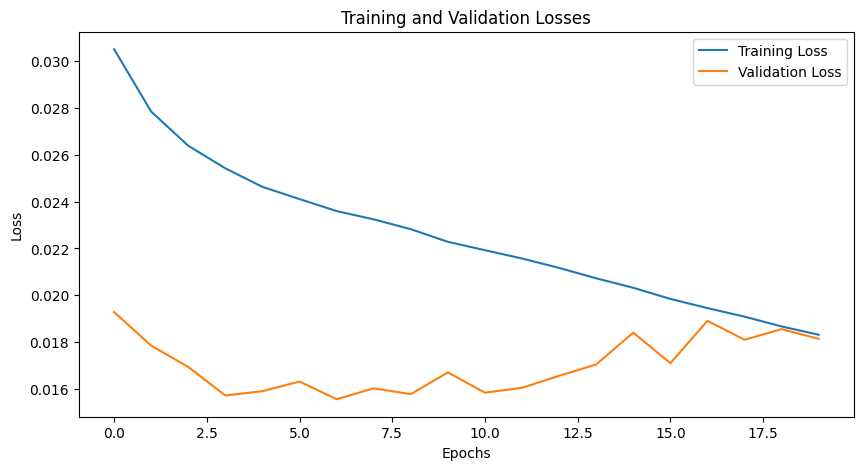

In [39]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
runtime.unassign()